In [2]:
import os
import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.transforms import blended_transform_factory
# import shutil
import pandas as pd
# import numpy as np
# import ast

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Read all category csv files

In [4]:
topic_csv_dir = "topic_csv"

all_data_df = pd.read_csv(f"{topic_csv_dir}/all_results.csv")
print(f"Loaded file {topic_csv_dir}/all_results.csv with shape {all_data_df.shape}")
# convert Image column value to string
all_data_df["Image"] = all_data_df["Image"].astype(str)

# list all csv files in the directory
csv_files = [f for f in os.listdir(topic_csv_dir) if f != "all_results.csv"]
print(f"Now:, concatenating: {csv_files}")

# read all csv files and concatenate them into one dataframe
all_topic_df = pd.concat([pd.read_csv(os.path.join(topic_csv_dir, f)) for f in csv_files])
all_topic_df["Image"] = all_topic_df["Image"].astype(str)
print(f"Concatenated all csv files into one dataframe with shape {all_topic_df.shape}")

Loaded file topic_csv/all_results.csv with shape (90605, 37)
Now:, concatenating: ['K. Immigration and migration.csv', 'Q. Security.csv', 'P. Methodological research.csv', 'C. Science and technology.csv', 'N. Economy and work.csv', 'B. Religion and spirituality.csv', 'G. International affairs.csv', 'O. Regions and countries.csv', 'E. Demographics.csv', 'J. News habits and media.csv', 'A. Social values and attitudes.csv', 'D. Politics and policy.csv', 'L. Family and relationships.csv', 'M. Race and ethnicity.csv', 'I. Gender and LGBTQ.csv']
Concatenated all csv files into one dataframe with shape (90605, 37)


In [5]:
unique_questions_df = all_topic_df[all_topic_df['Image'] == 'True'][['question_topic', 'question_text', 'md_sim_topic', 'question_topic_mean_similarity','question_topic_country_mean_similarity', 'country']].drop_duplicates()
unique_questions_df = unique_questions_df.groupby(['question_topic', 'country'])
unique_questions_df.head(2)

,question_topic,question_text,md_sim_topic,question_topic_mean_similarity,question_topic_country_mean_similarity,country
418,K. Immigration and migration,"From your point of view, what have been the ef...",0.532984,0.582754,0.628471,Brazil
425,K. Immigration and migration,"From your point of view, what have been the ef...",0.599773,0.582754,0.628471,Brazil
466,K. Immigration and migration,"From your point of view, what have been the ef...",0.637143,0.582754,0.557279,China
474,K. Immigration and migration,"From your point of view, what have been the ef...",0.599773,0.582754,0.557279,China
514,K. Immigration and migration,"Do you agree, disagree or neither agree nor di...",0.614894,0.582754,0.704474,France
...,...,...,...,...,...,...
511,I. Gender and LGBTQ,Please tell me for each of the following state...,0.613713,0.526206,0.464948,South Korea
536,I. Gender and LGBTQ,Please tell me for each of the following state...,0.551371,0.526206,0.568119,United States
544,I. Gender and LGBTQ,How frequently do the following things occur i...,0.632784,0.526206,0.568119,United States
568,I. Gender and LGBTQ,Please tell me for each of the following state...,0.551371,0.526206,0.504731,Vietnam


### Plot Question Topic level similarity and JSD values for each country
- This is per country
- Note that all images are for people of same demographic group

In [6]:
all_data_df.columns

Index(['img_id', 'image_path', 'country', 'image_code', 'income',
       'question_text', 'country_prompt', 'generic_prompt', 'option_labels',
       'full_options', 'prompt', 'options', 'top10_token_prob',
       'prob_percent_sorted', 'sum_prob_percent_sorted', 'prob_percent_keys',
       'prob_percent_values', 'selection_answers', 'img_category', 'jsd',
       'similarity', 'Image', 'model_size', 'country_mean_jsd',
       'coutry_mean_similarity', 'question_topic', 'question_topic_mean_jsd',
       'question_topic_mean_similarity',
       'question_topic_country_mean_similarity', 'md_topic_pred',
       'md_topic_gt', 'md_all_pred', 'md_all_gt', 'md_jsd_topic',
       'md_sim_topic', 'md_jsd_overall', 'md_sim_overall'],
      dtype='object')

In [7]:
rich_countries = ["United States", "France", "South Korea", "Italy"]
medium_countries = ["Brazil", "Mexico", "China"]
poor_countries = ["Pakistan", "Nigeria", "Vietnam"]

country_list = rich_countries + medium_countries + poor_countries

In [8]:
# Define the order of countries based on ease of English language usage to different cultural languages
country_order_language = ['United States', 'South Korea', 'France', 'Italy', 'Brazil', 'Mexico', 'China', 'Pakistan', 'Nigeria', 'Vietnam']

# Ensure the country_list is ordered based on the new language order
country_list = sorted(country_list, key=lambda x: country_order_language.index(x))

print(country_list)

['United States', 'South Korea', 'France', 'Italy', 'Brazil', 'Mexico', 'China', 'Pakistan', 'Nigeria', 'Vietnam']


In [9]:
print(all_data_df['Image'].unique())
print(all_topic_df['Image'].dtype)

['False' 'True']
object


In [42]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory

# Directory to save individual figures
individual_figures_dir = 'plots/individual_topic'
if os.path.exists(individual_figures_dir):
    shutil.rmtree(individual_figures_dir)
    print(f"Existed! Deleted {individual_figures_dir} directory")
os.makedirs(individual_figures_dir, exist_ok=True)

# List of unique question topics
question_topics = sorted(all_data_df['question_topic'].unique())

# List of unique models
models = sorted(all_data_df['model_size'].unique())

# Define a multi-column layout (3 columns by default)
n_cols = 3
n_rows = int(np.ceil(len(question_topics) / n_cols))

# Slightly increase figure size to give more space
fig_width = 7 * n_cols
fig_height = 4.5 * n_rows

# Create subplots in a grid
fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
axs = axs.flatten()  # Flatten to 1D for simpler indexing

# Set bar width/gap for the final multi-subplot figure
bar_width = 0.10
gap = 0.12  # smaller gap so the bars within each country group are closer

for idx, topic in enumerate(question_topics):
    # -----------------------
    # Filter data for the topic
    # -----------------------
    df_category = all_data_df[all_data_df['question_topic'] == topic].copy()

    # Convert Image column to boolean
    df_category.loc[:, 'Image'] = df_category['Image'].map({'False': False, 'True': True})

    # Group and calculate means
    df_mean = (
        df_category
        .groupby(['country', 'Image', 'model_size'])[['question_topic_country_mean_similarity', 'md_sim_topic']]
        .mean()
        .reset_index()
    )

    # Pivot to have separate columns for Image = True/False
    df_pivot = df_mean.pivot_table(
        index=['country', 'model_size'],
        columns='Image',
        values='question_topic_country_mean_similarity'
    ).reset_index()

    # Calculate Baseline Similarity (where Image=True)
    baseline_similarity = (
        df_mean[df_mean['Image'] == True]
        .groupby(['country', 'model_size'])['md_sim_topic']
        .mean()
        .reset_index()
        .rename(columns={'md_sim_topic': 'Baseline Similarity'})
    )

    # Merge baseline into df_pivot
    df_pivot = df_pivot.merge(baseline_similarity, on=['country', 'model_size'], how='left')

    # Drop rows without baseline
    df_pivot.dropna(subset=['Baseline Similarity'], inplace=True)

    # Rename columns for clarity
    df_pivot.rename(columns={False: 'Text Similarity', True: 'Image Similarity'}, inplace=True)

    # Ensure columns exist in case any are missing
    for col in ['Text Similarity', 'Image Similarity', 'Baseline Similarity']:
        if col not in df_pivot.columns:
            df_pivot[col] = np.nan

    # Sort countries if you have a predefined list
    df_pivot['country'] = pd.Categorical(df_pivot['country'], categories=country_list, ordered=True)
    df_pivot.sort_values('country', inplace=True)

    # Create a complete grid of (country, model_size)
    all_combinations = pd.MultiIndex.from_product(
        [country_list, models], names=['country', 'model_size']
    ).to_frame(index=False)
    df_pivot = all_combinations.merge(df_pivot, on=['country', 'model_size'], how='left')

    # Drop rows with missing data in any key columns
    df_pivot.dropna(subset=['Text Similarity', 'Image Similarity', 'Baseline Similarity'], inplace=True)

    # -----------------------
    # Plot on multi-subplot figure
    # -----------------------
    ax = axs[idx]
    countries = df_pivot['country'].unique()

    # Compress x positions to reduce overall space between countries
    x_positions = np.arange(len(countries)) * 0.8  # multiply by <1 to bring them closer

    n_models = len(models)
    group_width = n_models * bar_width + (n_models - 1) * gap

    # Legend flags (so each label appears only once)
    bigf_has_plotted_text = False
    bigf_has_plotted_image = False

    for model_idx, model in enumerate(models):
        # Filter and align data for the current model
        df_model = df_pivot[df_pivot['model_size'] == model].copy()
        df_model = df_model.set_index('country').reindex(countries).reset_index()
        df_model.dropna(subset=['Text Similarity', 'Image Similarity', 'Baseline Similarity'], inplace=True)

        # Some countries may have been dropped (if no data), so recalc x
        x_valid = np.arange(len(df_model)) * 0.8
        start_offset = -group_width / 2 + bar_width / 2
        offset = start_offset + model_idx * (bar_width + gap)

        # Text bars
        if not bigf_has_plotted_text:
            ax.bar(
                x_valid + offset,
                df_model['Text Similarity'],
                bar_width,
                label='Country (no image)',
                color='orange'
            )
            bigf_has_plotted_text = True
        else:
            ax.bar(x_valid + offset, df_model['Text Similarity'], bar_width, color='orange')

        # Image bars
        if not bigf_has_plotted_image:
            ax.bar(
                x_valid + offset + bar_width,
                df_model['Image Similarity'],
                bar_width,
                label='Image (no country name)',
                color='rebeccapurple'
            )
            bigf_has_plotted_image = True
        else:
            ax.bar(x_valid + offset + bar_width, df_model['Image Similarity'], bar_width, color='rebeccapurple')

        # Model label under each group of bars
        for i in range(len(x_valid)):
            center_position = x_valid[i] + offset + bar_width / 2
            ax.text(
                center_position, -0.01,
                model, ha='center', va='top',
                fontsize=6, color='black',
                transform=ax.get_xaxis_transform()
            )

    # Subplot title & axes settings
    topic_title = topic.split('.', 1)[-1].strip()
    ax.set_title(topic_title, fontsize=9)
    ax.set_ylabel('Mean Similarity')
    ax.set_ylim([0, 1])
    
    ax.set_xticks(x_valid)
    ax.set_xticklabels(df_model['country'].values, rotation=30, ha='right', fontsize=8)
    ax.xaxis.set_tick_params(pad=5)

    # -----------------------------------
    # Create separate individual figure
    # -----------------------------------
    fig_individual, ax_individual = plt.subplots(figsize=(10, 4))

    # Keep smaller bars & gap as well
    bar_width_indiv = 0.10
    gap_indiv = 0.12
    group_width_indiv = n_models * bar_width_indiv + (n_models - 1) * gap_indiv

    has_plotted_text = False
    has_plotted_image = False

    for model_idx, model in enumerate(models):
        df_model = df_pivot[df_pivot['model_size'] == model].copy()
        df_model = df_model.set_index('country').reindex(countries).reset_index()
        df_model.dropna(subset=['Text Similarity', 'Image Similarity', 'Baseline Similarity'], inplace=True)

        # Recompute x
        x_indiv = np.arange(len(df_model)) * 0.8
        start_offset_indiv = -group_width_indiv / 2 + bar_width_indiv / 2
        offset_indiv = start_offset_indiv + model_idx * (bar_width_indiv + gap_indiv)

        # Text
        if not has_plotted_text:
            ax_individual.bar(
                x_indiv + offset_indiv,
                df_model['Text Similarity'],
                bar_width_indiv,
                label='Country (no image)',
                color='orange'
            )
            has_plotted_text = True
        else:
            ax_individual.bar(
                x_indiv + offset_indiv,
                df_model['Text Similarity'],
                bar_width_indiv,
                color='orange'
            )

        # Image
        if not has_plotted_image:
            ax_individual.bar(
                x_indiv + offset_indiv + bar_width_indiv,
                df_model['Image Similarity'],
                bar_width_indiv,
                label='Image (no country name)',
                color='rebeccapurple'
            )
            has_plotted_image = True
        else:
            ax_individual.bar(
                x_indiv + offset_indiv + bar_width_indiv,
                df_model['Image Similarity'],
                bar_width_indiv,
                color='rebeccapurple'
            )

        # Model labels
        for i in range(len(x_indiv)):
            center_position = x_indiv[i] + offset_indiv + bar_width_indiv / 2
            ax_individual.text(
                center_position, -0.01,
                model, ha='center', va='top',
                fontsize=6, color='black'
            )

    ax_individual.set_title(topic_title, fontsize=9)
    ax_individual.set_ylabel('Mean Similarity')
    ax_individual.set_ylim([0, 1])
    ax_individual.set_xticks(x_indiv)
    ax_individual.set_xticklabels(df_model['country'].values, rotation=30, ha='right', fontsize=8)
    
    # Legend for individual figure
    ax_individual.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=8)
    
    fig_individual.tight_layout(rect=[0, 0, 0.8, 1])
    fig_individual.savefig(os.path.join(individual_figures_dir, f'{topic_title}.png'), bbox_inches='tight')
    plt.close(fig_individual)

# Remove any unused subplots if total subplots > number of topics
for idx in range(len(question_topics), n_rows * n_cols):
    fig.delaxes(axs[idx])

# Adjust the layout for the final figure
plt.tight_layout(rect=[0, 0, 0.90, 1])

# Single legend for the entire multi-subplot figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.90, 0.5), frameon=False)

# Save final multi-subplot figure
fig.savefig(os.path.join(individual_figures_dir, 'final_similarity_plot.png'), bbox_inches='tight')
plt.close(fig)


Existed! Deleted plots/individual_topic directory


In [ ]:
# import os
# import shutil
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib.transforms import blended_transform_factory

# # Directory to save individual figures
# individual_figures_dir = 'plots/individual_topic'
# if os.path.exists(individual_figures_dir):
#     shutil.rmtree(individual_figures_dir)
#     print(f"Existed! Deleted {individual_figures_dir} directory")
# os.makedirs(individual_figures_dir, exist_ok=True)

# # List of unique question topics
# question_topics = sorted(all_data_df['question_topic'].unique())

# # List of unique models
# models = sorted(all_data_df['model_size'].unique())

# # Define a multi-column layout (3 columns by default)
# n_cols = 3
# n_rows = int(np.ceil(len(question_topics) / n_cols))

# # Define figure size
# fig_width = 6 * n_cols
# fig_height = 4 * n_rows

# # Create subplots in a grid
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
# axs = axs.flatten()  # Flatten to 1D for simpler indexing

# for idx, topic in enumerate(question_topics):
#     # Filter data for the current topic
#     df_category = all_data_df[all_data_df['question_topic'] == topic].copy()
    
#     # Convert Image to boolean
#     df_category.loc[:, 'Image'] = df_category['Image'].map({'False': False, 'True': True})

#     # Group and calculate means
#     df_mean = (
#         df_category
#         .groupby(['country', 'Image', 'model_size'])[['question_topic_country_mean_similarity', 'md_sim_topic']]
#         .mean()
#         .reset_index()
#     )

#     # Pivot to have separate columns for Image = True/False
#     df_pivot = df_mean.pivot_table(
#         index=['country', 'model_size'],
#         columns='Image',
#         values='question_topic_country_mean_similarity'
#     ).reset_index()

#     # Calculate Baseline Similarity (where Image=True)
#     baseline_similarity = (
#         df_mean[df_mean['Image'] == True]
#         .groupby(['country', 'model_size'])['md_sim_topic']
#         .mean()
#         .reset_index()
#         .rename(columns={'md_sim_topic': 'Baseline Similarity'})
#     )

#     # Merge baseline into df_pivot
#     df_pivot = df_pivot.merge(baseline_similarity, on=['country', 'model_size'], how='left')

#     # Drop rows without baseline
#     df_pivot.dropna(subset=['Baseline Similarity'], inplace=True)

#     # Rename columns for clarity
#     df_pivot.rename(columns={False: 'Text Similarity', True: 'Image Similarity'}, inplace=True)

#     # Ensure columns exist (in case any are missing)
#     for col in ['Text Similarity', 'Image Similarity', 'Baseline Similarity']:
#         if col not in df_pivot.columns:
#             df_pivot[col] = np.nan

#     # Sort countries if you have a predefined country_list
#     df_pivot['country'] = pd.Categorical(df_pivot['country'], categories=country_list, ordered=True)
#     df_pivot.sort_values('country', inplace=True)

#     # Create a complete grid of (country, model_size)
#     all_combinations = pd.MultiIndex.from_product(
#         [country_list, models],
#         names=['country', 'model_size']
#     ).to_frame(index=False)
#     df_pivot = all_combinations.merge(df_pivot, on=['country', 'model_size'], how='left')

#     # Drop rows with missing data in any key columns
#     df_pivot.dropna(subset=['Text Similarity', 'Image Similarity', 'Baseline Similarity'], inplace=True)

#     # Prepare for plotting
#     ax = axs[idx]
#     countries = df_pivot['country'].unique()
#     x = np.arange(len(countries))  # the x positions (one per country)

#     n_models = len(models)
#     bar_width = 0.10
#     gap = 0.12  # horizontal spacing between bars
#     group_width = n_models * bar_width + (n_models - 1) * gap  # total bar group width

#     # Legend control flags (so each label appears only once)
#     bigf_has_plotted_text = False
#     bigf_has_plotted_image = False

#     for model_idx, model in enumerate(models):
#         df_model = df_pivot[df_pivot['model_size'] == model].copy()
#         # Align row order with the main 'countries'
#         df_model = df_model.set_index('country').reindex(countries).reset_index()

#         # Drop rows with missing values
#         df_model.dropna(subset=['Text Similarity', 'Image Similarity', 'Baseline Similarity'], inplace=True)
#         # Recompute x for valid rows
#         x = np.arange(len(df_model))

#         # Offset so bars are centered around each x
#         start_offset = -group_width / 2 + bar_width / 2
#         offset = start_offset + model_idx * (bar_width + gap)

#         # Plot Text bars
#         if not bigf_has_plotted_text:
#             ax.bar(
#                 x + offset,
#                 df_model['Text Similarity'],
#                 bar_width,
#                 label='Country (no image)',   # <--- updated label
#                 color='orange'
#             )
#             bigf_has_plotted_text = True
#         else:
#             ax.bar(x + offset, df_model['Text Similarity'], bar_width, color='orange')

#         # Plot Image bars
#         if not bigf_has_plotted_image:
#             ax.bar(
#                 x + offset + bar_width,
#                 df_model['Image Similarity'],
#                 bar_width,
#                 label='Image (no country name)',   # <--- updated label
#                 color='rebeccapurple'
#             )
#             bigf_has_plotted_image = True
#         else:
#             ax.bar(x + offset + bar_width, df_model['Image Similarity'], bar_width, color='rebeccapurple')

#         # Add model label below each pair of bars: final 
#         for i in range(len(x)):
#             center_position = x[i] + offset + bar_width / 2
#             ax.text(
#                 center_position, -0.01,
#                 model, ha='center', va='top',
#                 fontsize=5, color='black', rotation=45, 
#                 transform=ax.get_xaxis_transform()
#             )

#     # Title & axes settings for this subplot - final
#     topic_title = topic.split('.', 1)[-1].strip()
#     ax.set_title(f'{topic_title}')
#     ax.set_ylabel('Mean Similarity')
#     ax.set_ylim([0, 1])
#     ax.set_xticks(np.arange(len(df_model)))
#     ax.set_xticklabels(df_model['country'].values, rotation=45, ha='right', fontsize=8, rotation_mode='anchor')
#     ax.xaxis.set_tick_params(pad=12)

#     # Create a separate individual figure for each topic
#     fig_individual, ax_individual = plt.subplots(figsize=(15, 4))

#     # Rebuild bars for the individual figure
#     has_plotted_text = False
#     has_plotted_image = False

#     # Adjust bar sizes or use the same ones
#     bar_width_indiv = 0.10
#     gap_indiv = 0.11
#     group_width_indiv = n_models * bar_width_indiv + (n_models - 1) * gap_indiv

#     for model_idx, model in enumerate(models):
#         df_model = df_pivot[df_pivot['model_size'] == model].copy()
#         df_model = df_model.set_index('country').reindex(countries).reset_index()
#         df_model.dropna(subset=['Text Similarity', 'Image Similarity', 'Baseline Similarity'], inplace=True)

#         x = np.arange(len(df_model))
#         start_offset = -group_width_indiv / 2 + bar_width_indiv / 2
#         offset = start_offset + model_idx * (bar_width_indiv + gap_indiv)

#         # Plot Text
#         if not has_plotted_text:
#             ax_individual.bar(
#                 x + offset,
#                 df_model['Text Similarity'],
#                 bar_width_indiv,
#                 label='Country (no image)',
#                 color='orange'
#             )
#             has_plotted_text = True
#         else:
#             ax_individual.bar(x + offset, df_model['Text Similarity'], bar_width_indiv, color='orange')

#         # Plot Image
#         if not has_plotted_image:
#             ax_individual.bar(
#                 x + offset + bar_width_indiv,
#                 df_model['Image Similarity'],
#                 bar_width_indiv,
#                 label='Image (no country name)',
#                 color='rebeccapurple'
#             )
#             has_plotted_image = True
#         else:
#             ax_individual.bar(
#                 x + offset + bar_width_indiv,
#                 df_model['Image Similarity'],
#                 bar_width_indiv,
#                 color='rebeccapurple'
#             )

#         # Model labels individually
#         for i in range(len(x)):
#             center_position = x[i] + offset + bar_width_indiv / 2
#             ax_individual.text(
#                 center_position, -0.05,
#                 model, ha='center', va='bottom',
#                 fontsize=6, color='black'
#             )

#     # Styling for the individual plot
#     ax_individual.set_title(f'{topic_title}')
#     ax_individual.set_ylabel('Mean Similarity')
#     ax_individual.set_ylim([0, 1])
#     ax_individual.set_yticks(np.arange(0, 1.1, 0.1))
#     ax_individual.set_xticks(np.arange(len(df_model)))
#     ax_individual.set_xticklabels(df_model['country'].values, rotation=45, ha='right')

#     # Put legend off to the right (inside or outside) for the individual figure
#     ax_individual.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=6)

#     fig_individual.tight_layout(rect=[0, 0, 0.8, 1])
#     fig_individual.savefig(os.path.join(individual_figures_dir, f'{topic_title}.png'), bbox_inches='tight')
#     plt.close(fig_individual)

# # Remove any unused subplots if total subplots > number of topics
# for idx in range(len(question_topics), n_rows * n_cols):
#     fig.delaxes(axs[idx])

# plt.tight_layout(rect=[0, 0, 0.95, 1])

# # Add a single legend for the entire multi-subplot figure
# handles, labels = axs[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.95, 0.5), frameon=False)

# # Save the final figure with all subplots
# fig.savefig(os.path.join(individual_figures_dir, 'final_similarity_plot.png'), bbox_inches='tight')
# plt.close(fig)

Existed! Deleted plots/individual_topic directory


In [ ]:
# import os
# import shutil
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib.transforms import blended_transform_factory
# # from tqdm import tqdm

# # Directory to save individual figures
# individual_figures_dir = 'plots/individual_topic'
# if os.path.exists(individual_figures_dir):
#     shutil.rmtree(individual_figures_dir)
#     print(f"Existed! Deleted {individual_figures_dir} directory")
# os.makedirs(individual_figures_dir, exist_ok=True)

# # List of unique question topics
# question_topics = sorted(all_data_df['question_topic'].unique())
# models = sorted(all_data_df['model_size'].unique())

# # Prepare for plotting
# n_cols = 1  # Number of subplots per row
# n_rows = int(np.ceil(len(question_topics) / n_cols))

# fig_width = 6 * n_cols
# fig_height = 4 * n_rows
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
# axs = axs.flatten()  # Flatten the array of axes

# # Loop through each topic to create subplots
# for idx, topic in enumerate(question_topics):
#     df_category = all_data_df[all_data_df['question_topic'] == topic]

#     # Prepare DataFrame by calculating means for each combination of 'country', 'Image', and 'model_size'
#     df_category.loc[:, 'Image'] = df_category['Image'].map({'False': False, 'True': True})
    
#     # Calculate mean 'question_topic_mean_similarity' and 'md_sim_topic' per country, Image scenario, and model_size
#     df_mean = df_category.groupby(['country', 'Image', 'model_size'])[['question_topic_country_mean_similarity', 'md_sim_topic']].mean().reset_index()

#     # Pivot the data to have Image scenarios as columns (Text Similarity, Image Similarity, and Baseline)
#     df_pivot = df_mean.pivot_table(
#         index=['country', 'model_size'], 
#         columns='Image', 
#         values='question_topic_country_mean_similarity'
#     ).reset_index()
    
#     # Handle the three columns for baseline, text, and image similarity
#     # Calculate Baseline Similarity
#     baseline_similarity = df_mean[df_mean['Image'] == True].groupby(['country', 'model_size'])['md_sim_topic'].mean().reset_index()
#     baseline_similarity = baseline_similarity.rename(columns={'md_sim_topic': 'Baseline Similarity'})

#     # Merge Baseline Similarity with df_pivot
#     df_pivot = df_pivot.merge(
#         baseline_similarity, 
#         on=['country', 'model_size'], 
#         how='left'
#     )
    

#     # # Drop rows where 'Baseline Similarity' is NaN
#     df_pivot = df_pivot.dropna(subset=['Baseline Similarity'])
#     df_pivot = df_pivot.rename(columns={False: 'Text Similarity', True: 'Image Similarity'})

#     # Ensure all similarity columns exist
#     for col in ['Text Similarity', 'Image Similarity', 'Baseline Similarity']:
#         if col not in df_pivot.columns:
#             df_pivot[col] = np.nan
    
#     # breakpoint()
#     # Sort countries based on 'country_list'
#     df_pivot['country'] = pd.Categorical(df_pivot['country'], categories=country_list, ordered=True)
#     df_pivot = df_pivot.sort_values('country')
    
#     # Create a MultiIndex of all possible combinations
#     all_combinations = pd.MultiIndex.from_product(
#         [country_list, models],
#         names=['country', 'model_size']
#     ).to_frame(index=False)

#     # Merge with df_pivot to ensure all combinations are present
#     df_pivot = all_combinations.merge(df_pivot, on=['country', 'model_size'], how='left')

#     # Drop rows with missing data
#     df_pivot = df_pivot.dropna()
    
#     # Data for plotting
#     countries = df_pivot['country'].unique()
#     baseline_similarities = df_pivot['Baseline Similarity']
#     text_similarities = df_pivot['Text Similarity']
#     image_similarities = df_pivot['Image Similarity']
    
#     x = np.arange(len(countries))  # Label locations
#     width = 0.15  # Width of the bars for each model
#     gap_between_models = 0.13  # A larger gap between the two models' sets of bars

#     ax = axs[idx]
    
#     bigf_has_plotted_text = False
#     bigf_has_plotted_image = False
#     # Loop through models and plot for each
#     for model_idx, model in enumerate(models):
#         df_model = df_pivot[df_pivot['model_size'] == model]
        
#         # Align df_model to have all countries, but do not fill missing values
#         df_model = df_model.set_index('country').reindex(countries).reset_index()
        
#         # Drop rows where any of the similarity columns are NaN
#         df_model = df_model.dropna(subset=['Text Similarity', 'Image Similarity', 'Baseline Similarity'])
        
#         # Recalculate x based on the length of df_model
#         x = np.arange(len(df_model))
        
#         offset = model_idx * (width * 1.5 + gap_between_models)  # Offset between different models
    
        
#         # Plot bars for baseline, text, and image similarity
#         if not bigf_has_plotted_text:
#             ax.bar(x + offset, df_model['Text Similarity'], width, label='Text', color='orange')
#             bigf_has_plotted_text = True
#         else:
#             ax.bar(x + offset, df_model['Text Similarity'], width, color='orange')
            
#         if not bigf_has_plotted_image:
#             ax.bar(x + offset + width, df_model['Image Similarity'], width, label=f'Image', color='rebeccapurple')
#             bigf_has_plotted_image = True
#         else:
#             ax.bar(x + offset + width, df_model['Image Similarity'], width, color='rebeccapurple')
        
#         # Add model name annotation below the group of bars
#         for i in range(len(x)):
#             # Calculate the center position for the model label
#             center_position = x[i] + offset + width / 2
#             ax.text(center_position, -0.02, model, ha='center', va='top', fontsize=6, color='black', transform=ax.get_xaxis_transform())  # Adjust position as needed

    
#     # Compute the mean similarity for the topic using text-level data only
#     text_mean = df_pivot['Text Similarity'].mean()

    
#     # Remove prefix (e.g., 'A.', 'B.', etc.) from topic name
#     topic_title = topic.split('.', 1)[-1].strip()
    
#     # Add labels, title, and custom x-axis tick labels
#     ax.set_ylabel('Mean Similarity')
#     ax.set_title(f'{topic_title}')
#     ax.set_xticks(x + width)  # Adjust x-axis to center
#     ax.set_xticklabels(countries, rotation=45)  # Set x-tick labels (country names)
#     ax.tick_params(axis='x', which='major', labelsize=8, pad=12)  # Adjust font size and appearance
#     ax.set_ylim([0, 1])  # Set y-axis limits to [0, 1]
    
#     # Create individual figure for the topic
#     fig_individual, ax_individual = plt.subplots(figsize=(15, 4))
    
#     # Set the width of each bar and define the number of models
#     width = 0.15  # Set the width for the bars
#     gap_between_models = 0.35  # A larger gap between the two models' sets of bars


#     # To ensure only one legend entry per type (Text, Baseline, Image)
#     has_plotted_text = False
#     # has_plotted_baseline = False
#     has_plotted_image = False


#     for model_idx, model in enumerate(models):
#         df_model = df_pivot[df_pivot['model_size'] == model]
        
#         # Align df_model to have all countries, but do not fill missing values
#         df_model = df_model.set_index('country').reindex(countries).reset_index()
        
#         # Drop rows where any of the similarity columns are NaN
#         df_model = df_model.dropna(subset=['Text Similarity', 'Image Similarity', 'Baseline Similarity'])
        
#         # Recalculate x based on the length of df_model
#         x = np.arange(len(df_model))
        
#         # Calculate the offset to center the bars around each x-tick
#         if model_idx == 0:
#             offset = -gap_between_models / 2
#         else:
#             offset = gap_between_models / 2
        
#         # Plot the Text bars
#         if not has_plotted_text:
#             ax_individual.bar(x + offset - width / 2, df_model['Text Similarity'], width, label='Text', color='orange')
#             has_plotted_text = True
#         else:
#             ax_individual.bar(x + offset - width / 2, df_model['Text Similarity'], width, color='orange')

#         # Plot the Image bars
#         if not has_plotted_image:
#             ax_individual.bar(x + offset + width / 2, df_model['Image Similarity'], width, label='Image', color='rebeccapurple')
#             has_plotted_image = True
#         else:
#             ax_individual.bar(x + offset + width / 2, df_model['Image Similarity'], width, color='rebeccapurple')
        
#         # Add model name annotation below the group of bars
#         for i in range(len(x)):
#             center_position = x[i] + offset + width / 2
#             ax_individual.text(center_position, -0.05, model, ha='center', va='bottom', fontsize=6, color='black')
  
#     # Add labels, title, and custom x-axis tick labels
#     ax_individual.set_ylabel('Mean Similarity')
#     ax_individual.set_title(f'{topic_title}')
#     # Set x-ticks to be at the center of the groups of bars
#     # The middle point of each set of bars is `x + offset` for the second model, so we can set the x-ticks for that
#     x_tick_positions = x + gap_between_models / 2  # Centered at the midpoint of the grouped bars
#     ax_individual.set_xticks(x_tick_positions)  # Set x-tick positions
#     ax_individual.set_xticklabels(countries)  # Set x-tick labels (country names)
#     ax_individual.tick_params(axis='x', which='major', labelsize=10, pad=12)  # Adjust font size and appearance
#     # set y max limit to 1
#     ax_individual.set_ylim([0, 1])
#     ax_individual.yaxis.set_ticks(np.arange(0, 1.1, 0.1))  # Set y-axis ticks in steps of 0.1

    
#     # Add legend to individual figure, located in the upper right corner outside the plot area
#     ax_individual.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=6)
    
#     # Adjust layout to make room for the legend
#     fig_individual.tight_layout(rect=[0, 0, 0.8, 1])  # Leave space on the right for the legend
    
#     # Save individual figure
#     fig_individual.savefig(os.path.join(individual_figures_dir, f'{topic_title}.png'), bbox_inches='tight')
#     plt.close(fig_individual)  # Close the figure to free memory
    
# # Remove empty subplots if any
# for idx in range(len(question_topics), n_rows * n_cols):
#     fig.delaxes(axs[idx])

# # Adjust layout to make room for the legend
# plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave less space on the right

# # Add a single legend on the right
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.0, 0.5), frameon=False)

# # Save the final figure with all subplots
# fig.savefig(f'{individual_figures_dir}/final_similarity_plot.png', bbox_inches='tight')

# # plt.show()
# plt.close(fig)  # Close the figure to free memory


Existed! Deleted plots/individual_topic directory


### Variance (Difference) of Mean Similarities

### Percentage Change in Mean Similarities


This works with 2 models

Fixed version of working with 2 model - GPT help

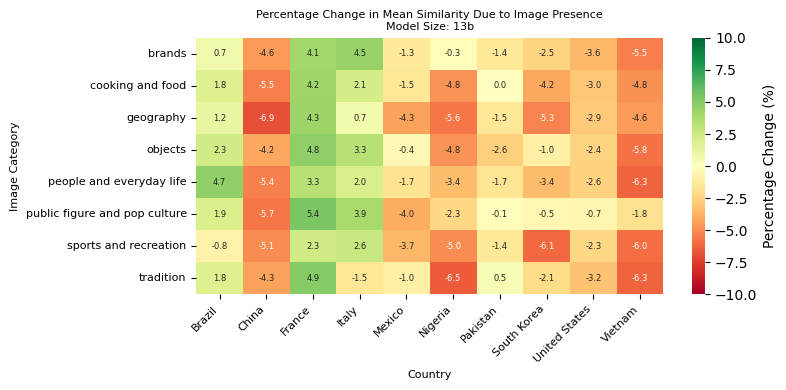

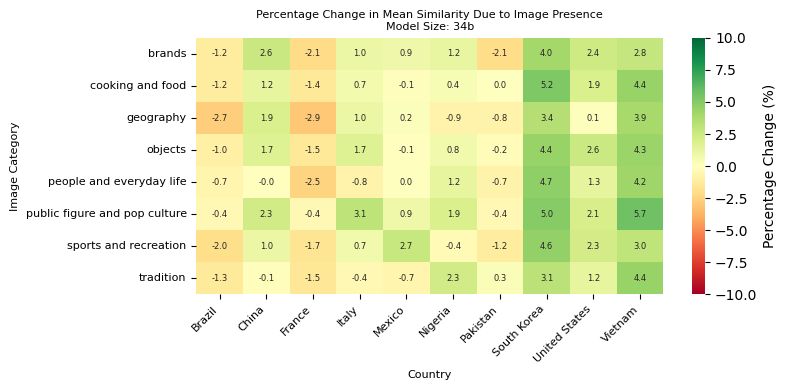

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = all_data_df.copy()
# Ensure 'Image' column is boolean
df['Image'] = df['Image'].map({'True': True, 'False': False}).astype(bool)

# Get the list of unique model sizes
model_sizes = df['model_size'].unique()

# Loop over each model size and generate the heatmap
for model in model_sizes:
    # Filter the DataFrame for the current model size
    df_model = df[df['model_size'] == model]

    # Step 1: Compute mean similarities with and without images for the current model size

    # Mean similarity when Image is True
    mean_sim_with_image = df_model[df_model['Image'] == True].groupby(['img_category', 'country'])['similarity'].mean().reset_index()
    mean_sim_with_image.rename(columns={'similarity': 'mean_sim_with_image'}, inplace=True)
    
    # Mean similarity when Image is False
    mean_sim_without_image = df_model[df_model['Image'] == False].groupby(['img_category', 'country'])['similarity'].mean().reset_index()
    mean_sim_without_image.rename(columns={'similarity': 'mean_sim_without_image'}, inplace=True)
    
    # Step 2: Merge the two DataFrames using an inner join (consistent with previous code)
    mean_sim = pd.merge(mean_sim_with_image, mean_sim_without_image, on=['img_category', 'country'], how='inner')
    
    # Step 3: Calculate percentage change
    # Avoid division by zero by replacing zeros in the denominator unconditionally (as in previous code)
    epsilon = 1e-6
    mean_sim['mean_sim_without_image'].replace(0, epsilon, inplace=True)
    
    mean_sim['percentage_change'] = ((mean_sim['mean_sim_with_image'] - mean_sim['mean_sim_without_image']) / mean_sim['mean_sim_without_image']) * 100
    
    # Step 4: Pivot the DataFrame
    percentage_change_pivot = mean_sim.pivot(index='img_category', columns='country', values='percentage_change')
    
    # Optional: Handle infinite values and missing data
    percentage_change_pivot.replace([np.inf, -np.inf], np.nan, inplace=True)
    percentage_change_pivot.fillna(0, inplace=True)
    
    # Step 5: Plot the heatmap with consistent parameters
    plt.figure(figsize=(8, 4))
    sns.heatmap(
        percentage_change_pivot,
        annot=True,
        fmt=".1f",
        cmap='RdYlGn',
        vmin=-10,
        vmax=10,
        cbar_kws={'label': 'Percentage Change (%)'},
        annot_kws={"size": 6}  # Adjust the size as needed
    )
    
    # Customizing the plot
    plt.title(f'Percentage Change in Mean Similarity Due to Image Presence\nModel Size: {model}', fontsize=8)
    plt.ylabel('Image Category', fontsize=8)
    plt.xlabel('Country', fontsize=8)
    plt.yticks(
        ticks=np.arange(len(percentage_change_pivot.index)) + 0.5,
        labels=[label.replace('_', ' ').lower() for label in percentage_change_pivot.index],
        rotation=0,
        fontsize=8
    )
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.tight_layout()
    plt.savefig(f'plots/percentage_change_heatmap_category_{model}.png', bbox_inches='tight', dpi=500)
    plt.show()


Should work with 3 model

In [ ]:
# # This should also work

# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# df = all_data_df.copy()
# # Ensure 'Image' column is boolean
# df['Image'] = df['Image'].map({'True': True, 'False': False}).astype(bool)

# # Get the list of unique model sizes
# model_sizes = df['model_size'].unique()

# # Loop over each model size and generate the heatmap
# for model in model_sizes:
#     # Filter the DataFrame for the current model size
#     df_model = df[df['model_size'] == model]

#     # Step 1: Compute mean similarities with and without images for the current model size

#     # Mean similarity when Image is True
#     mean_sim_with_image = df_model[df_model['Image'] == True].groupby(['img_category', 'country'])['similarity'].mean().reset_index()
#     mean_sim_with_image.rename(columns={'similarity': 'mean_sim_with_image'}, inplace=True)
    
#     # Mean similarity when Image is False
#     mean_sim_without_image = df_model[df_model['Image'] == False].groupby(['img_category', 'country'])['similarity'].mean().reset_index()
#     mean_sim_without_image.rename(columns={'similarity': 'mean_sim_without_image'}, inplace=True)
    
#     # Step 2: Merge the two DataFrames
#     mean_sim = pd.merge(mean_sim_with_image, mean_sim_without_image, on=['img_category', 'country'], how='inner')
    
#     # Step 3: Calculate percentage change
#     # Avoid division by zero by replacing zeros in the denominator
#     epsilon = 1e-6
#     mean_sim['mean_sim_without_image'].replace(0, epsilon, inplace=True)
    
#     mean_sim['percentage_change'] = ((mean_sim['mean_sim_with_image'] - mean_sim['mean_sim_without_image']) / mean_sim['mean_sim_without_image']) * 100
    
#     # Step 4: Pivot the DataFrame
#     percentage_change_pivot = mean_sim.pivot(index='img_category', columns='country', values='percentage_change')
    
#     # Optional: Handle infinite values and missing data
#     percentage_change_pivot.replace([np.inf, -np.inf], np.nan, inplace=True)
#     # replace NaN with 0
#     percentage_change_pivot.fillna(0, inplace=True)
#     # Clip the data to be within 0% to 100%
#     # percentage_change_pivot_clipped = percentage_change_pivot.clip(lower=0, upper=100)
    
#     # Step 5: Plot the heatmap with color bar from 0% to 100%
#     plt.figure(figsize=(8, 4))
#     sns.heatmap(
#         percentage_change_pivot,
#         annot=True,
#         fmt=".1f",
#         cmap='RdYlGn',
#         vmin=-20,
#         vmax=20,
#         cbar_kws={'label': 'Percentage Change (%)'},
#         annot_kws={"size": 6}  # Change the size of the numbers in the heatmap
#     )
    
#     # Customizing the plot
#     plt.title(f'Percentage Change in Mean Similarity Due to Image Presence\nModel Size: {model}', fontsize=8)
#     plt.ylabel('Image Category', fontsize=8)
#     plt.xlabel('Country', fontsize=8)
#     plt.yticks(ticks=np.arange(len(percentage_change_pivot.index)), labels=[label.replace('_', ' ').lower() for label in percentage_change_pivot.index])
    
#     # Rotate x-axis labels
#     plt.xticks(rotation=45, ha='right', fontsize=8)
#     plt.yticks(fontsize=8)
    
#     plt.tight_layout()
#     plt.savefig(f'plots/percentage_change_heatmap_category_{model}.png', bbox_inches='tight', dpi=500)
#     plt.show()


### Ratio of Mean Similarities


In [ ]:
# # Create a cross-join to see all possible combinations of question_topic and country
# all_combinations = pd.MultiIndex.from_product([mean_sim['question_topic'].unique(), 
#                                                mean_sim['country'].unique()], 
#                                                names=['question_topic', 'country'])

# # Reindex mean_sim to find missing combinations
# reindexed_mean_sim = mean_sim.set_index(['question_topic', 'country']).reindex(all_combinations).reset_index()

# # Find rows where percentage_change is NaN (missing combinations)
# missing_combinations = reindexed_mean_sim[reindexed_mean_sim['percentage_change'].isna()]
# print("Missing combinations of 'question_topic' and 'country':")
# print(missing_combinations[['question_topic', 'country']])


### Percntage Change in Mean Similarities at Question Topic level

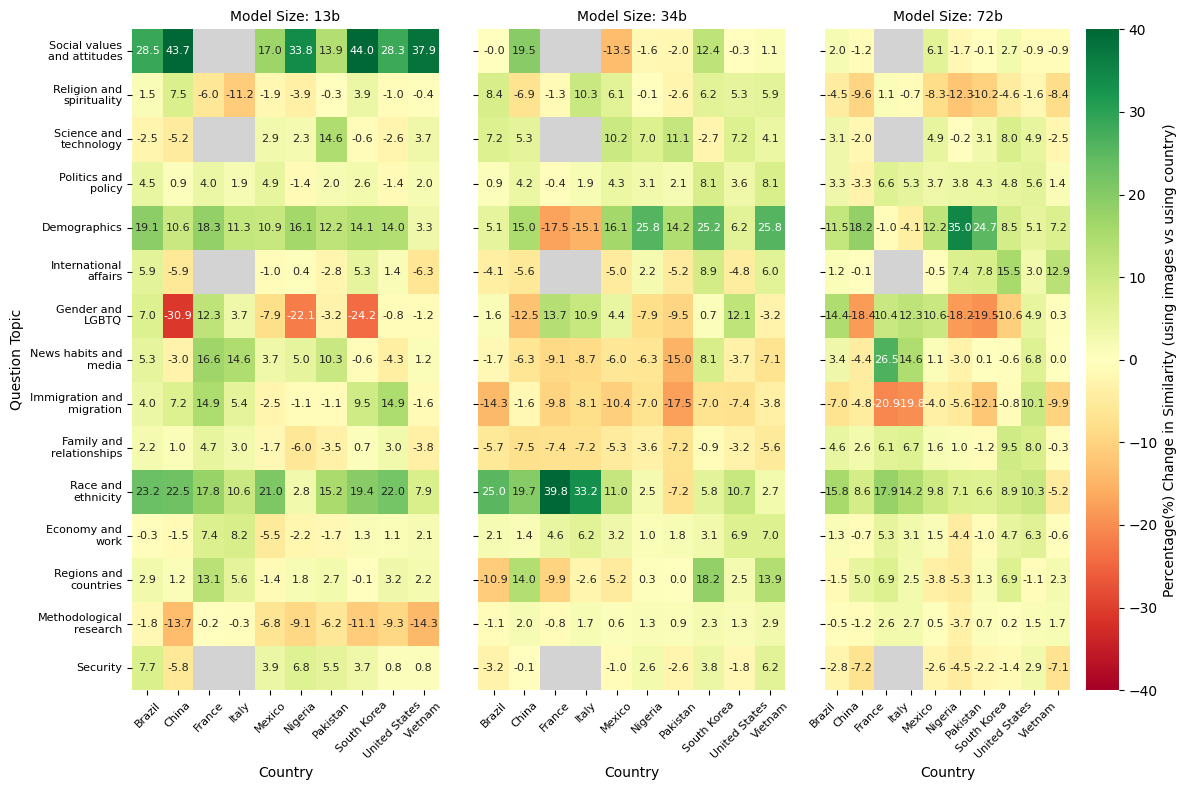

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from textwrap import wrap

df = all_data_df.copy()
# Ensure 'Image' column is boolean
df['Image'] = df['Image'].map({'True': True, 'False': False}).astype(bool)

# Get the list of unique model sizes
model_sizes = df['model_size'].unique()

# Adjust figure size based on the number of question topics
num_topics = df['question_topic'].nunique()
fig_height = max(8, num_topics * 0.01)

# fig_height = 6
# Create a figure with subplots
fig, axes = plt.subplots(1, len(model_sizes), figsize=(12, fig_height), sharey=True)

# Loop over each model size and generate the heatmap
for idx, model in enumerate(model_sizes):
    # Filter the DataFrame for the current model size
    df_model = df[df['model_size'] == model]

    # Compute mean similarities with and without images
    mean_sim_with_image = df_model[df_model['Image'] == True].groupby(['question_topic', 'country'])['similarity'].mean().reset_index()
    mean_sim_with_image.rename(columns={'similarity': 'mean_sim_with_image'}, inplace=True)
    
    mean_sim_without_image = df_model[df_model['Image'] == False].groupby(['question_topic', 'country'])['similarity'].mean().reset_index()
    mean_sim_without_image.rename(columns={'similarity': 'mean_sim_without_image'}, inplace=True)
    
    # Merge the two DataFrames
    mean_sim = pd.merge(mean_sim_with_image, mean_sim_without_image, on=['question_topic', 'country'], how='inner')
    
    # Calculate percentage change
    epsilon = 1e-6
    mean_sim['mean_sim_without_image'].replace(0, epsilon, inplace=True)
    mean_sim['percentage_change'] = ((mean_sim['mean_sim_with_image'] - mean_sim['mean_sim_without_image']) / mean_sim['mean_sim_without_image']) * 100
    
    # Pivot the DataFrame
    breakpoint()
    percentage_change_pivot = mean_sim.pivot(index='question_topic', columns='country', values='percentage_change')
    # percentage_change_pivot = mean_sim.pivot(index='country', columns='question_topic', values='percentage_change')
    
    # Handle infinite values and missing data
    percentage_change_pivot.replace([np.inf, -np.inf], np.nan, inplace=True)
    # percentage_change_pivot.fillna(0, inplace=True)
    # percentage_change_pivot_clipped = percentage_change_pivot.clip(lower=0, upper=100)
    percentage_change_pivot_clipped = percentage_change_pivot
    
    # Define a colormap with grey for NaN values
    cmap = sns.diverging_palette(240, 10, as_cmap=True)  # RdYlGn-like colormap
    cmap = plt.get_cmap('RdYlGn')  # Get the RdYlGn colormap
    cmap.set_bad(color='lightgrey')  # Set color for NaN values
    
    # Plot the heatmap in the subplot
    sns.heatmap(
        percentage_change_pivot_clipped,
        annot=True,
        fmt=".1f",
        cmap=cmap,
        vmin=-40,
        vmax=40,
        cbar=(idx == len(model_sizes) - 1),  # Show color bar only on the last subplot
        ax=axes[idx],
        cbar_kws={'label': 'Percentage(%) Change in Similarity (using images vs using country)'} if idx == len(model_sizes) - 1 else None,
        annot_kws={"size": 8},
        mask=percentage_change_pivot_clipped.isna(),  # Mask NaN values
    )
    
    # Customize the subplot
    axes[idx].set_title(f'Model Size: {model}', fontsize=10)
    axes[idx].set_xlabel('Country')
    if idx == 0:
        axes[idx].set_ylabel('Question Topic')
    else:
        axes[idx].set_ylabel('')
    
    # Rotate x-axis labels
    axes[idx].tick_params(axis='x', rotation=45, labelsize=8)
    # Adjust y-axis labels font size
    axes[idx].tick_params(axis='y', labelsize=8)

    # Adjust wrap width based on label length
    wrapped_labels = ['\n'.join(wrap(label.split('. ', 1)[-1], 15)) for label in percentage_change_pivot_clipped.index]
    axes[idx].set_yticklabels(wrapped_labels, fontsize=8, rotation=0)
    

plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=8)

plt.tight_layout()
plt.savefig('plots/percentage_change_heatmap_topic_models.png', bbox_inches='tight', dpi=500)
plt.show()


### Compute average similarity for each country with and withour images

In [23]:
all_data_df.columns

Index(['img_id', 'image_path', 'country', 'image_code', 'income',
       'question_text', 'country_prompt', 'generic_prompt', 'option_labels',
       'full_options', 'prompt', 'options', 'top10_token_prob',
       'prob_percent_sorted', 'sum_prob_percent_sorted', 'prob_percent_keys',
       'prob_percent_values', 'selection_answers', 'img_category', 'jsd',
       'similarity', 'Image', 'model_size', 'country_mean_jsd',
       'coutry_mean_similarity', 'question_topic', 'question_topic_mean_jsd',
       'question_topic_mean_similarity',
       'question_topic_country_mean_similarity', 'md_topic_pred',
       'md_topic_gt', 'md_all_pred', 'md_all_gt', 'md_jsd_topic',
       'md_sim_topic', 'md_jsd_overall', 'md_sim_overall'],
      dtype='object')

In [24]:
import pandas as pd

# Assuming your DataFrame is named df and includes the columns:
# 'question_text', 'country', 'similarity', 'Image', and 'model'

df = all_data_df.copy()

# Step 1: Group by 'country', 'model', and 'Image' to calculate the mean similarity
mean_similarity = df.groupby(['model_size', 'Image', 'country', 'question_text'])['similarity'].mean().reset_index()
mean_similarity['similarity'] = mean_similarity['similarity'].round(2)

# Step 2: Pivot the DataFrame to have countries as columns and 'Image' as rows
mean_similarity_pivot = mean_similarity.pivot_table(
    index=['model_size', 'Image'],
    columns='country',
    values='similarity'
).reset_index()

# rename Image column to Condition. Map True to 'Image (no country name)' and False to 'Country name (no image)'
mean_similarity_pivot['Condition'] = mean_similarity_pivot['Image'].map({'True': 'Image (no country name)', 'False': 'Country name (no image)'})
# Display the result
mean_similarity_pivot.drop(columns=['Image'], inplace=True)
mean_similarity_pivot.set_index(['model_size', 'Condition'], inplace=True)
mean_similarity_pivot


country                               Brazil     China    France     Italy  \
model_size Condition                                                         
13b        Country name (no image)  0.601327  0.547345  0.600522  0.604783   
           Image (no country name)  0.611469  0.519379  0.625565  0.617652   
34b        Country name (no image)  0.691848  0.680904  0.734870  0.716957   
           Image (no country name)  0.683128  0.689661  0.721652  0.722957   
72b        Country name (no image)  0.641238  0.666893  0.647913  0.660261   
           Image (no country name)  0.645403  0.654633  0.676087  0.683217   

country                               Mexico   Nigeria  Pakistan  South Korea  \
model_size Condition                                                            
13b        Country name (no image)  0.599726  0.600132  0.612333     0.533213   
           Image (no country name)  0.586210  0.575482  0.604714     0.516516   
34b        Country name (no image)  0.688082  0.698026  0.679429     0.649276   
           Image (no country name)  0.691416  0.703289  0.674429     0.677195   
72b        Country name (no image)  0.643991  0.688150  0.640335     0.627545   
           Image (no country name)  0.647169  0.671535  0.639381     0.642986   

country                             United States   Vietnam  
model_size Condition                                         
13b        Country name (no image)       0.581381  0.545981  
           Image (no country name)       0.566762  0.517895  
34b        Country name (no image)       0.730238  0.634880  
           Image (no country name)       0.743000  0.660813  
72b        Country name (no image)       0.680718  0.626250  
           Image (no country name)       0.702952  0.625072

#### Plot on world map

Global Min: -5.1890371048107475, Global Max: 4.386765039259957


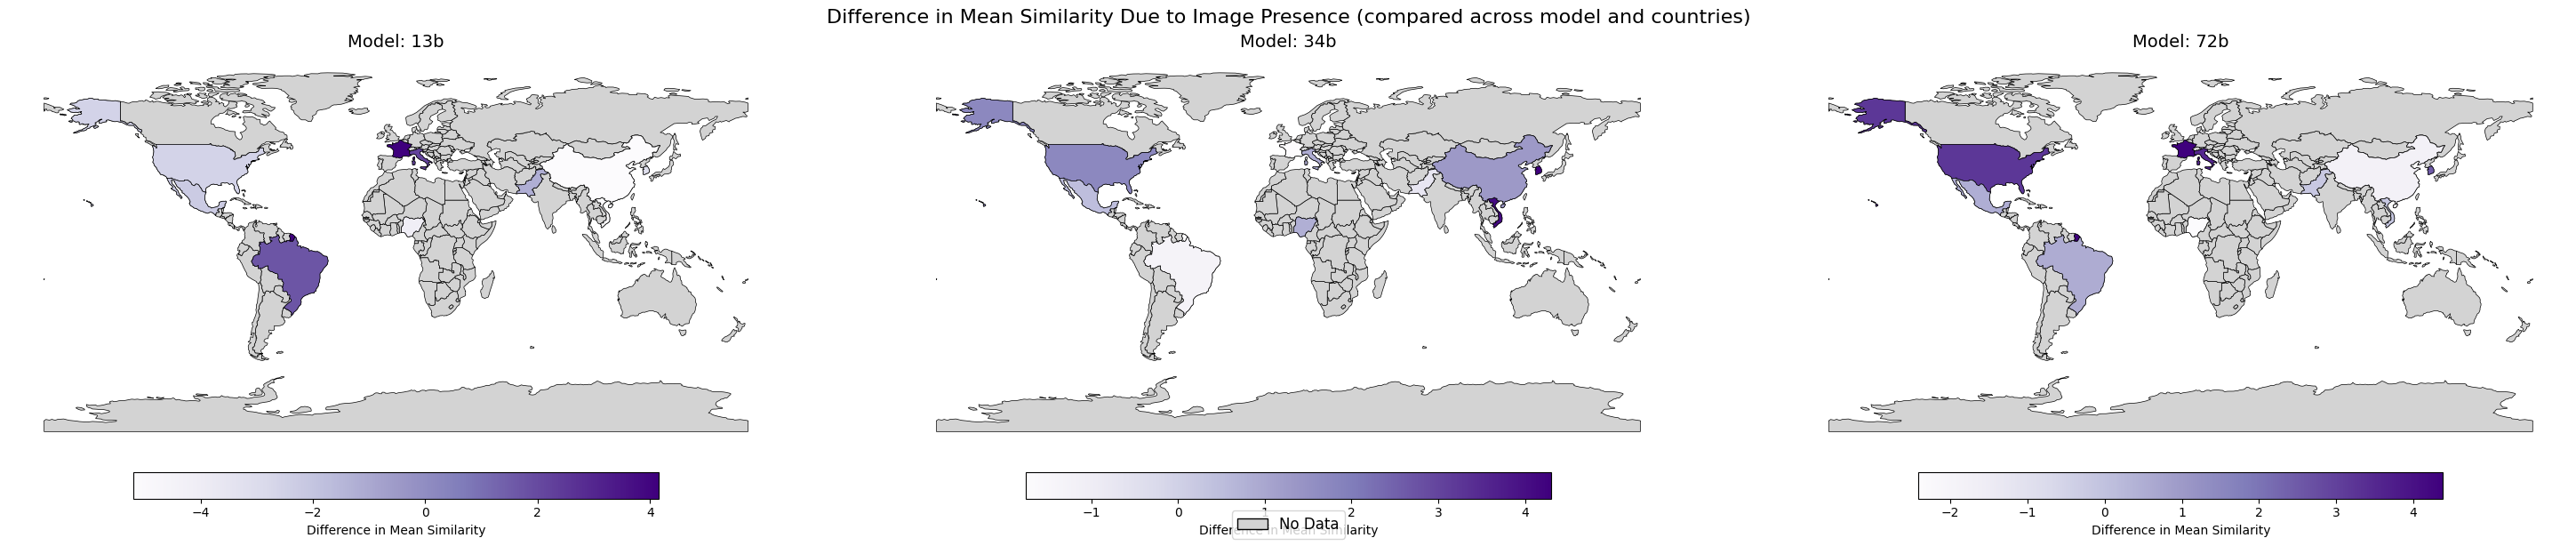

In [32]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pycountry
import matplotlib.patches as mpatches

# ---------------------------
# Step 1: Prepare the Data
# ---------------------------

# Assume all_data_df is your initial DataFrame
df = all_data_df.copy()

# Ensure 'Image' column is boolean
df['Image'] = df['Image'].map({'True': True, 'False': False}).astype(bool)

# Calculate mean similarity for each combination of 'model_size', 'Image', and 'country'
mean_similarity = df.groupby(['model_size', 'Image', 'country'])['similarity'].mean().reset_index()

# Pivot the DataFrame to have separate columns for 'Image=True' and 'Image=False'
mean_similarity_pivot = mean_similarity.pivot_table(
    index=['model_size', 'country'],
    columns='Image',
    values='similarity'
).reset_index()

# Rename the pivoted columns for clarity
mean_similarity_pivot.rename(columns={
    True: 'mean_similarity_with_image',
    False: 'mean_similarity_without_image'
}, inplace=True)

# Calculate the difference in mean similarity (Image=True minus Image=False)
mean_similarity_pivot['difference'] = (
    mean_similarity_pivot['mean_similarity_with_image'] - 
    mean_similarity_pivot['mean_similarity_without_image']
)

# Calculate the percentage change in mean similarity
mean_similarity_pivot['percentage_change'] = (
    (mean_similarity_pivot['difference'] / mean_similarity_pivot['mean_similarity_without_image']) * 100
)

# ---------------------------
# Step 2: Map Country Names to ISO Alpha-3 Codes
# ---------------------------

def get_iso3(country_name):
    """Convert country names to their ISO Alpha-3 codes."""
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except:
        return None

mean_similarity_pivot['iso_a3'] = mean_similarity_pivot['country'].apply(get_iso3)


# Remove entries with missing ISO codes
mean_similarity_pivot.dropna(subset=['iso_a3'], inplace=True)

# ---------------------------
# Step 3: Load and Merge World Map Data
# ---------------------------

# Load the Natural Earth dataset
world = gpd.read_file('../ne_110m_admin_0_countries.zip')

# Merge your similarity difference data with the world GeoDataFrame on 'iso_a3'
merged = world.merge(mean_similarity_pivot, how='left', left_on='ADM0_A3', right_on='iso_a3')

# ---------------------------
# Step 4: Plot the Data on a World Map
# ---------------------------

# Get unique model sizes
models = mean_similarity_pivot['model_size'].unique()
n_models = len(models)

# Set up the figure with subplots for each model
fig, axes = plt.subplots(1, n_models, figsize=(10 * n_models, 6), constrained_layout=True)

# Ensure 'axes' is iterable
if n_models == 1:
    axes = [axes]

# Define the colormap: 'Purples' where dark purple indicates higher difference
cmap = 'Purples'

# Determine global min and max for consistent color scaling
global_min = merged['percentage_change'].min()
global_max = merged['percentage_change'].max()

print(f"Global Min: {global_min}, Global Max: {global_max}")

# Plot each model in a separate subplot
for ax, model in zip(axes, models):
    # Filter data for the current model
    model_data = merged[merged['model_size'] == model]
    
    # Plot all countries in light grey
    world.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)
    
    # Plot countries with data using the 'Purples' colormap
    model_data.dropna(subset=['percentage_change']).plot(
        ax=ax,
        column='percentage_change',
        cmap=cmap,
        linewidth=0.5,
        edgecolor='black',
        legend=True,
        legend_kwds={
            'label': "Difference in Mean Similarity",
            'orientation': "horizontal",
            'shrink': 0.6,
            'pad': 0.05
        },
        vmin=model_data['percentage_change'].min(),
        vmax=model_data['percentage_change'].max()
    )
    
    # Set title and remove axes
    ax.set_title(f"Model: {model}", fontsize=14)
    ax.axis('off')

# Create a legend patch for "No Data"
no_data_patch = mpatches.Patch(facecolor='lightgrey', edgecolor='black', label='No Data')

# Add the "No Data" patch to the figure legend
fig.legend(handles=[no_data_patch], loc='lower center', ncol=1, fontsize=12)

# Add an overall title to the figure
fig.suptitle("Difference in Mean Similarity Due to Image Presence (compared across model and countries)", fontsize=16)
plt.savefig('plots/world_map.png', bbox_inches='tight')
# Show the plot
plt.show()


In [33]:
mnp = merged[merged['percentage_change'].notna()]
mnp_pivot = mnp.pivot(index='model_size', columns='country', values='percentage_change')
mnp_pivot.sort_values(by=mnp_pivot.columns.tolist(), ascending=False)

country,Brazil,China,France,Italy,Mexico,Nigeria,Pakistan,South Korea,United States,Vietnam
model_size,,,,,,,,,,
13b,1.683790,-5.189037,4.148954,2.189802,-2.262693,-4.095428,-1.194373,-3.140833,-2.578169,-5.151022
72b,0.541374,-1.830233,4.386765,3.511913,0.487885,-2.415026,-0.193183,2.452527,3.204111,-0.150530
34b,-1.327543,1.311885,-1.756037,0.870535,0.477360,0.816393,-0.733037,4.298559,1.720951,4.088651


In [34]:
all_data_df['country'].unique()

array(['Brazil', 'China', 'France', 'Italy', 'Mexico', 'Nigeria',
       'Pakistan', 'South Korea', 'United States', 'Vietnam'],
      dtype=object)

### Missing row where NaN exists